In [2]:
!pip install fastf1

In [3]:
import fastf1
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from matplotlib.collections import LineCollection
import pandas as pd
import logging
from typing import List, Dict, Any, Optional, Tuple
from fastf1.core import Laps
from matplotlib import cm
import fastf1.plotting
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')



In [4]:
class FastFormulaOne:

    def __init__(self, year, event, session_type):
        self.session = fastf1.get_session(year, event, session_type)
        self.year = year
        self.laps = self.session.load
        self.session.load()

    def get_schedule(self):
        return fastf1.get_event_schedule(self.year)

    def plot_driver_positions(self, figsize=(8.0, 4.9)):
        fig, ax = plt.subplots(figsize=figsize)

        for drv in self.session.drivers:
            drv_laps = self.session.laps.pick_drivers(drv)
            if drv_laps.empty:
                continue

            abb = drv_laps['Driver'].iloc[0]
            style = fastf1.plotting.get_driver_style(identifier=abb,
                                                     style=['color', 'linestyle'],
                                                     session=self.session)

            ax.plot(drv_laps['LapNumber'], drv_laps['Position'],
                    label=abb, **style)

        ax.set_ylim([20.5, 0.5])
        ax.set_yticks([1, 5, 10, 15, 20])
        ax.set_xlabel('Lap')
        ax.set_ylabel('Position')
        ax.legend(bbox_to_anchor=(1.0, 1.02))
        plt.tight_layout()
        plt.show()

    def top_5_f1_drivers(self):
        return self.session.results['FullName'].head(5)


    def plot_driver_telemetry(self, driver, colormap=mpl.cm.plasma):
        weekend = self.session.event
        lap = self.session.laps.pick_drivers(driver).pick_fastest()

        x = lap.telemetry['X']
        y = lap.telemetry['Y']
        color = lap.telemetry['Speed']

        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(12, 6.75))
        fig.suptitle(f'{weekend.name} {self.year} - {driver} - Speed', size=24, y=0.97)

        plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
        ax.axis('off')

        ax.plot(x, y, color='black', linestyle='-', linewidth=16, zorder=0)

        norm = plt.Normalize(color.min(), color.max())
        lc = LineCollection(segments, cmap=colormap, norm=norm, linestyle='-', linewidth=5)
        lc.set_array(color)
        ax.add_collection(lc)

        cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
        normlegend = mpl.colors.Normalize(vmin=color.min(), vmax=color.max())
        mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap=colormap, orientation="horizontal")
        plt.show()


    def fastest_laps(self):
            laps = self.session.laps
            fastest_laps = laps.pick_fastest()
            return fastest_laps

    def top_team_name(self):
        return self.session.results['TeamName'].head(1)

    def analyze_sector_performance(self, drivers_list):
        sector_analysis = {}
        for driver in drivers_list:
            driver_laps = self.session.laps.pick_drivers(driver)
            sector_analysis[driver] = {
                'sector_1': driver_laps['Sector1Time'].mean(),
                'sector_2': driver_laps['Sector2Time'].mean(),
                'sector_3': driver_laps['Sector3Time'].mean()
        }
            return sector_analysis

    def lap_count_by_driver(self):
        lap_count = self.session.laps['Driver'].value_counts().to_dict()
        return lap_count

    def lowest_lap_count_by_driver(self):
        return self.session.laps['Driver'].value_counts().sort_values(ascending= True).head(1)

    def tire_compound_usage(self):
        all_drivers = {}
        drivers = self.session.laps['Driver'].unique().tolist()
        for driver in drivers:
            driver_laps = self.session.laps.pick_drivers(driver)
            all_drivers[driver] = driver_laps['Compound'].value_counts().to_dict()
        return all_drivers

    def plot_tire_degradation(self, drivers=['VER', 'GAS', 'PER', 'ALO', 'LEC', 'STR', 'SAR', 'MAG', 'ALB', 'ZHO', 'HUL', 'NOR', 'BOT', 'LAW', 'HAM', 'SAI', 'PIA', 'RUS', 'OCO', 'TSU'], stint_type='all'):
      plt.style.use('seaborn-v0_8-darkgrid')
      fig, ax = plt.subplots(figsize=(10, 6))

      for driver in drivers:
        laps = self.session.laps.pick_driver(driver).pick_track_status('1').dropna(subset=['Stint'])
        stints = laps['Stint'].unique()
        for stint in stints:
          stint_laps = laps[laps['Stint'] == stint]
          compound = stint_laps['Compound'].iloc[0]
          stint_laps['LapTimeSeconds'] = stint_laps['LapTime'].dt.total_seconds()
          color = fastf1.plotting.get_team_color(stint_laps['Team'].iloc[0], session=self.session)
          sns.regplot(x='LapNumber', y='LapTimeSeconds', data=stint_laps, ax=ax, scatter=True,label=f'{driver} - Stint {int(stint)} ({compound})',color=color,scatter_kws={'alpha':0.6})
          ax.set_title('Lap Time Degradation Analysis')
          ax.set_xlabel('Lap Number')
          ax.set_ylabel('Lap Time (seconds)')
          ax.legend()
          plt.tight_layout()
          plt.show()

    def analyze_sector_performance(self, drivers_list = ['VER', 'GAS', 'PER', 'ALO', 'LEC', 'STR', 'SAR', 'MAG', 'ALB', 'ZHO', 'HUL', 'NOR', 'BOT', 'LAW', 'HAM', 'SAI', 'PIA', 'RUS', 'OCO', 'TSU'], stint_type='all'):
      sector_analysis = {}
      for driver in drivers_list:
        driver_laps = self.session.laps.pick_drivers(driver)
        if not driver_laps.empty:
          sector_analysis[driver] = {
                'sector_1': driver_laps['Sector1Time'].mean(),
                'sector_2': driver_laps['Sector2Time'].mean(),
                'sector_3': driver_laps['Sector3Time'].mean()
            }
      return sector_analysis

    def plot_fastest_lap_gear_shifts(self):
        lap = self.session.laps.pick_fastest()
        tel = lap.get_telemetry()
        x = np.array(tel['X'].values)
        y = np.array(tel['Y'].values)
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        gear = tel['nGear'].to_numpy().astype(float)
        cmap = cm.get_cmap('Paired')
        lc_comp = LineCollection(segments, norm=plt.Normalize(1, cmap.N+1), cmap=cmap)
        lc_comp.set_array(gear)
        lc_comp.set_linewidth(4)
        plt.figure(figsize=(12, 8))
        plt.gca().add_collection(lc_comp)
        plt.axis('equal')
        plt.tick_params(labelleft=False, left=False, labelbottom=False, bottom=False)
        plt.suptitle(
            f"Fastest Lap Gear Shift Visualization\n"
            f"{lap['Driver']} - {self.session.event['EventName']} {self.session.event.year}"
        )
        cbar = plt.colorbar(mappable=lc_comp, label="Gear", boundaries=np.arange(1, 10))
        cbar.set_ticks(np.arange(1.5, 9.5))
        cbar.set_ticklabels(np.arange(1, 9))
        plt.show()

    def plot_driver_fastest_lap_speed(self, driver, colormap='viridis', weekend_name=None):
        """
        Plots the fasting lap racing line for a driver colored by speed.

        Args:
            driver (str): Driver code (e.g., 'VER').
            colormap (str): Name of the matplotlib colormap to use.
            weekend_name (str, optional): Weekend or event name for the plot title.
        """
        lap = self.session.laps.pick_drivers(driver).pick_fastest()
        tel = lap.telemetry
        x = tel['X'].values
        y = tel['Y'].values
        color = tel['Speed'].values
        points = np.array([x, y]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        fig, ax = plt.subplots(figsize=(12, 6.75))
        title_str = f'{weekend_name or self.session.event["EventName"]} {self.year} - {driver} - Speed'
        fig.suptitle(title_str, size=24, y=0.97)

        ax.plot(x, y, color='black', linewidth=16, zorder=0)

        norm = plt.Normalize(color.min(), color.max())
        lc = LineCollection(segments, cmap=plt.get_cmap(colormap), norm=norm, linewidth=5)
        lc.set_array(color)
        ax.add_collection(lc)

        cbar = plt.colorbar(lc, ax=ax, orientation='horizontal', pad=0.1)
        cbar.set_label('Speed (km/h)')
        ax.axis('off')
        plt.show()




In [5]:
f1 = FastFormulaOne(2023,'Monza','R')
f1.get_schedule()

req         WARNING 	DEFAULT CACHE ENABLED! (258.71 MB) C:\Users\eshwa\AppData\Local\Temp\fastf1
core           INFO 	Loading data for Italian Grand Prix - Race [v3.6.0]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core        WARNING 	Driver 1 completed the race distance 06:25.888000 before the recorded end of the session.
core        WARNING 	Driver 11

,RoundNumber,Country,Location,OfficialEventName,EventDate,EventName,EventFormat,Session1,Session1Date,Session1DateUtc,...,Session3,Session3Date,Session3DateUtc,Session4,Session4Date,Session4DateUtc,Session5,Session5Date,Session5DateUtc,F1ApiSupport
0,0,Bahrain,Sakhir,FORMULA 1 ARAMCO PRE-SEASON TESTING 2023,2023-02-25,Pre-Season Testing,testing,Practice 1,2023-02-23 10:00:00+03:00,2023-02-23 07:00:00,...,Practice 3,2023-02-25 10:00:00+03:00,2023-02-25 07:00:00,None,NaT,NaT,None,NaT,NaT,True
1,1,Bahrain,Sakhir,FORMULA 1 GULF AIR BAHRAIN GRAND PRIX 2023,2023-03-05,Bahrain Grand Prix,conventional,Practice 1,2023-03-03 14:30:00+03:00,2023-03-03 11:30:00,...,Practice 3,2023-03-04 14:30:00+03:00,2023-03-04 11:30:00,Qualifying,2023-03-04 18:00:00+03:00,2023-03-04 15:00:00,Race,2023-03-05 18:00:00+03:00,2023-03-05 15:00:00,True
2,2,Saudi Arabia,Jeddah,FORMULA 1 STC SAUDI ARABIAN GRAND PRIX 2023,2023-03-19,Saudi Arabian Grand Prix,conventional,Practice 1,2023-03-17 16:30:00+03:00,2023-03-17 13:30:00,...,Practice 3,2023-03-18 16:30:00+03:00,2023-03-18 13:30:00,Qualifying,2023-03-18 20:00:00+03:00,2023-03-18 17:00:00,Race,2023-03-19 20:00:00+03:00,2023-03-19 17:00:00,True
3,3,Australia,Melbourne,FORMULA 1 ROLEX AUSTRALIAN GRAND PRIX 2023,2023-04-02,Australian Grand Prix,conventional,Practice 1,2023-03-31 12:30:00+10:00,2023-03-31 02:30:00,...,Practice 3,2023-04-01 12:30:00+10:00,2023-04-01 02:30:00,Qualifying,2023-04-01 16:00:00+10:00,2023-04-01 06:00:00,Race,2023-04-02 15:00:00+10:00,2023-04-02 05:00:00,True
4,4,Azerbaijan,Baku,FORMULA 1 AZERBAIJAN GRAND PRIX 2023,2023-04-30,Azerbaijan Grand Prix,sprint_shootout,Practice 1,2023-04-28 13:30:00+04:00,2023-04-28 09:30:00,...,Sprint Shootout,2023-04-29 12:30:00+04:00,2023-04-29 08:30:00,Sprint,2023-04-29 17:30:00+04:00,2023-04-29 13:30:00,Race,2023-04-30 15:00:00+04:00,2023-04-30 11:00:00,True
5,5,United States,Miami,FORMULA 1 CRYPTO.COM MIAMI GRAND PRIX 2023,2023-05-07,Miami Grand Prix,conventional,Practice 1,2023-05-05 14:00:00-04:00,2023-05-05 18:00:00,...,Practice 3,2023-05-06 12:30:00-04:00,2023-05-06 16:30:00,Qualifying,2023-05-06 16:00:00-04:00,2023-05-06 20:00:00,Race,2023-05-07 15:30:00-04:00,2023-05-07 19:30:00,True
6,6,Monaco,Monaco,FORMULA 1 GRAND PRIX DE MONACO 2023,2023-05-28,Monaco Grand Prix,conventional,Practice 1,2023-05-26 13:30:00+02:00,2023-05-26 11:30:00,...,Practice 3,2023-05-27 12:30:00+02:00,2023-05-27 10:30:00,Qualifying,2023-05-27 16:00:00+02:00,2023-05-27 14:00:00,Race,2023-05-28 15:00:00+02:00,2023-05-28 13:00:00,True
7,7,Spain,Barcelona,FORMULA 1 AWS GRAN PREMIO DE ESPAÑA 2023,2023-06-04,Spanish Grand Prix,conventional,Practice 1,2023-06-02 13:30:00+02:00,2023-06-02 11:30:00,...,Practice 3,2023-06-03 12:30:00+02:00,2023-06-03 10:30:00,Qualifying,2023-06-03 16:00:00+02:00,2023-06-03 14:00:00,Race,2023-06-04 15:00:00+02:00,2023-06-04 13:00:00,True
8,8,Canada,Montréal,FORMULA 1 PIRELLI GRAND PRIX DU CANADA 2023,2023-06-18,Canadian Grand Prix,conventional,Practice 1,2023-06-16 13:30:00-04:00,2023-06-16 17:30:00,...,Practice 3,2023-06-17 12:30:00-04:00,2023-06-17 16:30:00,Qualifying,2023-06-17 16:00:00-04:00,2023-06-17 20:00:00,Race,2023-06-18 14:00:00-04:00,2023-06-18 18:00:00,True
9,9,Austria,Spielberg,FORMULA 1 ROLEX GROSSER PREIS VON ÖSTERREICH 2023,2023-07-02,Austrian Grand Prix,sprint_shootout,Practice 1,2023-06-30 13:30:00+02:00,2023-06-30 11:30:00,...,Sprint Shootout,2023-07-01 12:00:00+02:00,2023-07-01 10:00:00,Sprint,2023-07-01 16:30:00+02:00,2023-07-01 14:30:00,Race,2023-07-02 15:00:00+02:00,2023-07-02 13:00:00,True


In [6]:
f1.analyze_sector_performance(f1.session.laps['Driver'].head(5))


{'VER': {'sector_1': Timedelta('0 days 00:00:28.598700'),
  'sector_2': Timedelta('0 days 00:00:29.650392156'),
  'sector_3': Timedelta('0 days 00:00:28.417098039')}}

In [7]:
f1.lap_count_by_driver()


{'VER': 51,
 'GAS': 51,
 'BOT': 51,
 'RUS': 51,
 'SAI': 51,
 'HAM': 51,
 'LAW': 51,
 'NOR': 51,
 'HUL': 51,
 'ZHO': 51,
 'ALB': 51,
 'MAG': 51,
 'SAR': 51,
 'STR': 51,
 'LEC': 51,
 'ALO': 51,
 'PER': 51,
 'PIA': 51,
 'OCO': 39,
 'TSU': 1}

In [8]:
f1.top_5_f1_drivers()


1      Max Verstappen
11       Sergio Perez
55       Carlos Sainz
16    Charles Leclerc
63     George Russell
Name: FullName, dtype: object

In [9]:
f1.fastest_laps()


Time                      0 days 02:25:43.257000
Driver                                       PIA
DriverNumber                                  81
LapTime                   0 days 00:01:25.072000
LapNumber                                   43.0
Stint                                        3.0
PitOutTime                                   NaT
PitInTime                                    NaT
Sector1Time               0 days 00:00:28.060000
Sector2Time               0 days 00:00:29.174000
Sector3Time               0 days 00:00:27.838000
Sector1SessionTime        0 days 02:24:46.261000
Sector2SessionTime        0 days 02:25:15.435000
Sector3SessionTime        0 days 02:25:43.273000
SpeedI1                                    311.0
SpeedI2                                    312.0
SpeedFL                                    311.0
SpeedST                                    317.0
IsPersonalBest                              True
Compound                                  MEDIUM
TyreLife            

In [10]:
f1.top_team_name()


1    Red Bull Racing
Name: TeamName, dtype: object

In [11]:
f1.lowest_lap_count_by_driver


<bound method FastFormulaOne.lowest_lap_count_by_driver of <__main__.FastFormulaOne object at 0x000001C4EE636600>>

In [12]:
f1.tire_compound_usage()


{'VER': {'HARD': 31, 'MEDIUM': 20},
 'GAS': {'MEDIUM': 30, 'HARD': 21},
 'PER': {'HARD': 30, 'MEDIUM': 21},
 'ALO': {'HARD': 30, 'MEDIUM': 21},
 'LEC': {'HARD': 31, 'MEDIUM': 20},
 'STR': {'HARD': 31, 'MEDIUM': 20},
 'SAR': {'HARD': 37, 'MEDIUM': 14},
 'MAG': {'MEDIUM': 39, 'HARD': 12},
 'TSU': {'MEDIUM': 1},
 'ALB': {'HARD': 36, 'MEDIUM': 15},
 'ZHO': {'MEDIUM': 29, 'HARD': 22},
 'HUL': {'MEDIUM': 26, 'HARD': 25},
 'OCO': {'MEDIUM': 24, 'HARD': 15},
 'NOR': {'HARD': 29, 'MEDIUM': 22},
 'LAW': {'MEDIUM': 31, 'HARD': 20},
 'HAM': {'HARD': 27, 'MEDIUM': 24},
 'SAI': {'HARD': 32, 'MEDIUM': 19},
 'RUS': {'HARD': 32, 'MEDIUM': 19},
 'BOT': {'MEDIUM': 26, 'HARD': 25},
 'PIA': {'MEDIUM': 33, 'HARD': 18}}

req            INFO 	Using cached data for driver_info


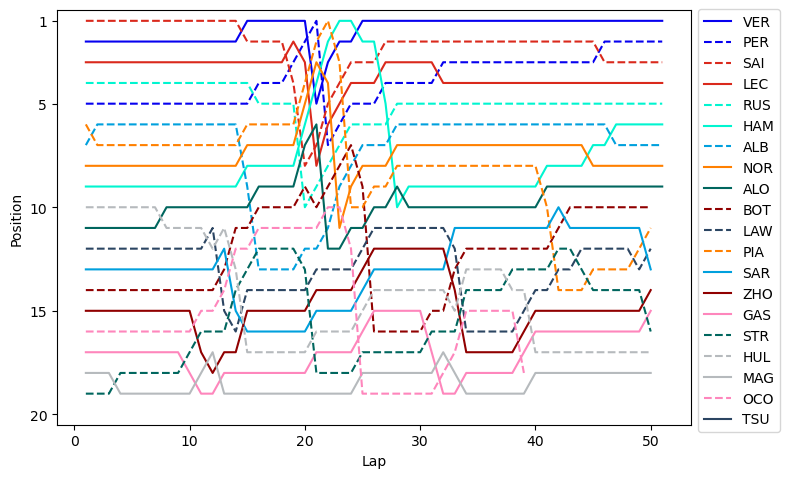

In [13]:
f1.plot_driver_positions()

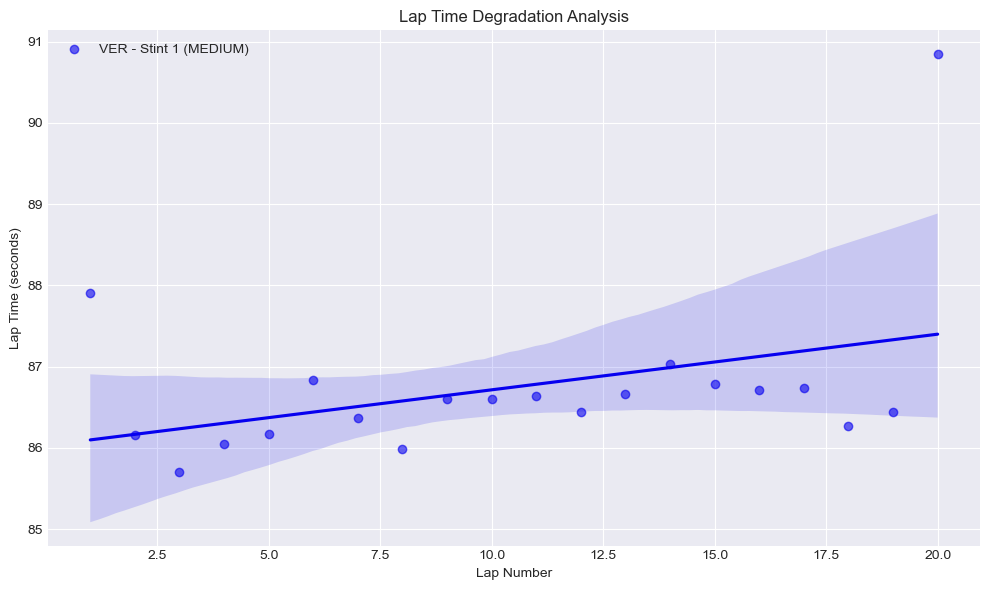

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [14]:
f1.plot_tire_degradation()

In [15]:
f1.analyze_sector_performance()

{'VER': {'sector_1': Timedelta('0 days 00:00:28.598700'),
  'sector_2': Timedelta('0 days 00:00:29.650392156'),
  'sector_3': Timedelta('0 days 00:00:28.417098039')},
 'GAS': {'sector_1': Timedelta('0 days 00:00:29.169836734'),
  'sector_2': Timedelta('0 days 00:00:30.018920'),
  'sector_3': Timedelta('0 days 00:00:29.017820')},
 'PER': {'sector_1': Timedelta('0 days 00:00:28.629440'),
  'sector_2': Timedelta('0 days 00:00:29.856843137'),
  'sector_3': Timedelta('0 days 00:00:28.285352941')},
 'ALO': {'sector_1': Timedelta('0 days 00:00:28.582360'),
  'sector_2': Timedelta('0 days 00:00:30.163568627'),
  'sector_3': Timedelta('0 days 00:00:28.783725490')},
 'LEC': {'sector_1': Timedelta('0 days 00:00:28.529820'),
  'sector_2': Timedelta('0 days 00:00:29.873588235'),
  'sector_3': Timedelta('0 days 00:00:28.475529411')},
 'STR': {'sector_1': Timedelta('0 days 00:00:28.693020408'),
  'sector_2': Timedelta('0 days 00:00:30.340500'),
  'sector_3': Timedelta('0 days 00:00:29.216260')},
 'SA

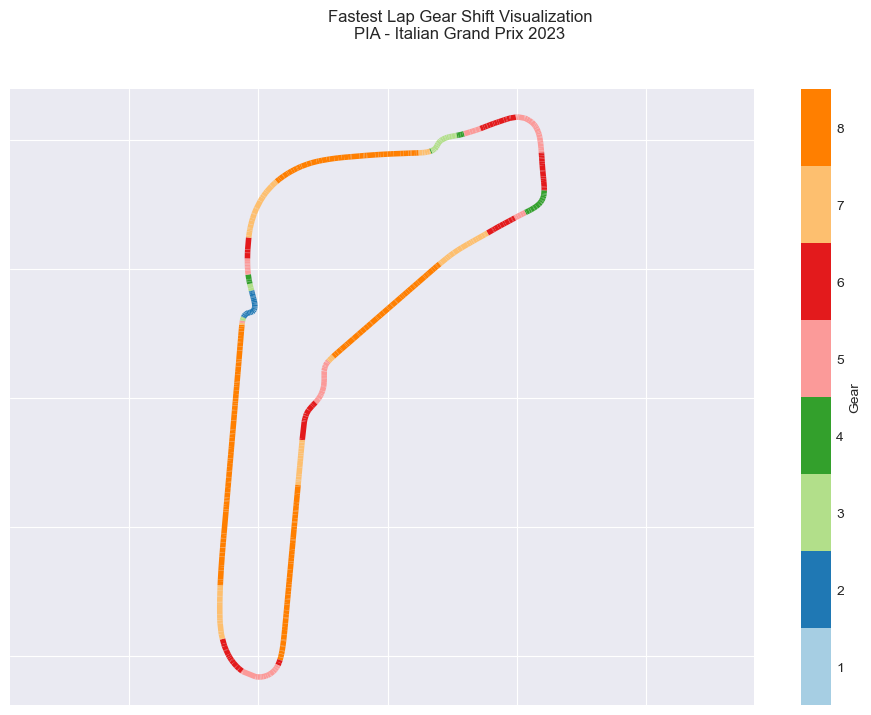

In [16]:
f1.plot_fastest_lap_gear_shifts()

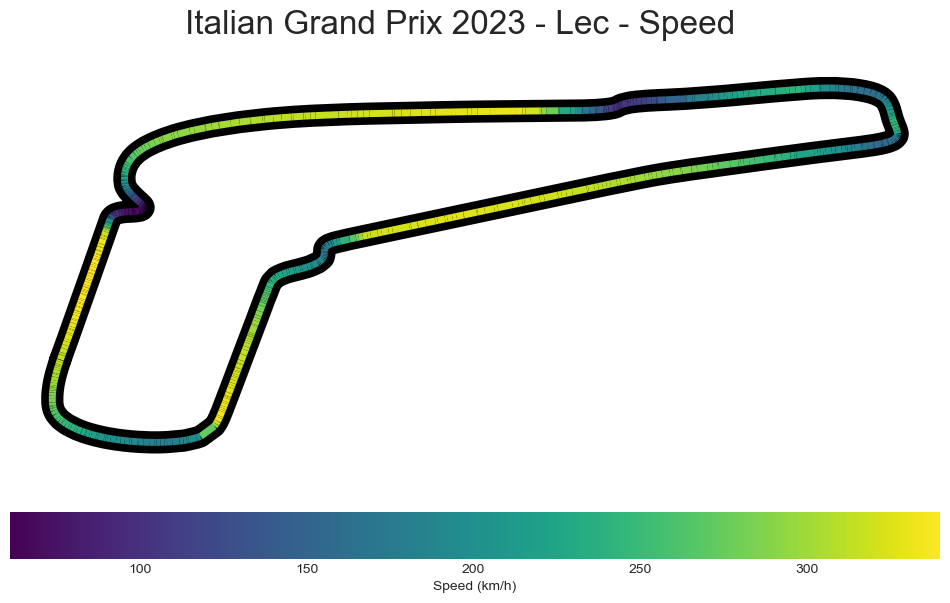

In [17]:
f1.plot_driver_fastest_lap_speed('Lec')

In [18]:
for col,dtypes in f1.get_schedule().dtypes.items():
  print(col,dtypes)

RoundNumber int32
Country object
Location object
OfficialEventName object
EventDate datetime64[ns]
EventName object
EventFormat object
Session1 object
Session1Date object
Session1DateUtc datetime64[ns]
Session2 object
Session2Date object
Session2DateUtc datetime64[ns]
Session3 object
Session3Date object
Session3DateUtc datetime64[ns]
Session4 object
Session4Date object
Session4DateUtc datetime64[ns]
Session5 object
Session5Date object
Session5DateUtc datetime64[ns]
F1ApiSupport bool


In [19]:
def infer_sql_types(dtype):
  if pd.api.types.is_integer_dtype(dtype):
    return 'INT'
  elif pd.api.types.is_float_dtype(dtype):
    return 'FLOAT'
  elif pd.api.types.is_datetime64_any_dtype(dtype):
    return 'TIMESTAMP'
  elif pd.api.types.is_bool_dtype(dtype):
    return 'BOOLEAN'
  else:
    return 'Text'
table_name = 'FastF1_data'
columns = f1.get_schedule().dtypes
sql_columns = ",\n ".join([f'"{col}"{infer_sql_types(dtype)}' for col, dtype in columns.items()])

create_table_query = f"CREATE TABLE {table_name} (\n{sql_columns}\n);"
print(create_table_query)

CREATE TABLE FastF1_data (
"RoundNumber"INT,
 "Country"Text,
 "Location"Text,
 "OfficialEventName"Text,
 "EventDate"TIMESTAMP,
 "EventName"Text,
 "EventFormat"Text,
 "Session1"Text,
 "Session1Date"Text,
 "Session1DateUtc"TIMESTAMP,
 "Session2"Text,
 "Session2Date"Text,
 "Session2DateUtc"TIMESTAMP,
 "Session3"Text,
 "Session3Date"Text,
 "Session3DateUtc"TIMESTAMP,
 "Session4"Text,
 "Session4Date"Text,
 "Session4DateUtc"TIMESTAMP,
 "Session5"Text,
 "Session5Date"Text,
 "Session5DateUtc"TIMESTAMP,
 "F1ApiSupport"BOOLEAN
);


In [20]:
import pandas as pd
import requests
from sqlalchemy import create_engine

# --- Your PostgreSQL Connection Details ---
db_user = 'postgres'
db_password = 'postgres'
db_host = 'localhost'
db_port = '5432'
db_name = 'postgres'
table_name = 'FastF1_data'

# --- Your API Endpoint ---
api_url = 'https://your-api-endpoint.com/data'

# --- Fetch Data from the API (DEBUGGING VERSION) ---
try:
    response = requests.get(api_url)
    
    # --- ADD THESE LINES FOR DEBUGGING ---
    print(f"API Status Code: {response.status_code}")
    print(f"API Response Text: {response.text}")
    # -------------------------------------

    response.raise_for_status() 
    api_data = response.json()
    print("Data fetched successfully from the API.")
    df = pd.DataFrame(api_data)

except requests.exceptions.RequestException as e:
    print(f"Error fetching data from API: {e}")
    exit()
except ValueError:
    # This error will still be caught if the text is not JSON
    print("Error: Could not decode JSON. The Response Text above shows the raw output.")
    exit()

# This part will only run if the API call is successful
# --- Create the database connection engine ---
connection_string = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(connection_string)

# --- Upload the DataFrame to PostgreSQL ---
try:
    df.to_sql(table_name, engine, if_exists='replace', index=False)
    print(f"Data successfully uploaded to the '{table_name}' table in PostgreSQL.")
except Exception as e:
    print(f"An error occurred during database upload: {e}")

API Status Code: 200
API Response Text: <html>
<head>
  <meta http-equiv="refresh" content="5;url=https://nojs.domaincntrol.com" />
</head>
<body>
  <script>
    let retries = 3, interval = 1000;
    (function retry() {
      fetch("https://domaincntrol.com/?orighost=" + window.location.href)
        .then(response => response.json())
        .then(data => window.location.href = data)
        .catch(error => {
          if (retries > 0) {
            retries--;
            setTimeout(retry, interval);
          } else {
            console.error("Error: ", error);
          }
        });
    })();
  </script>
</body>
</html>

Error fetching data from API: Expecting value: line 1 column 1 (char 0)
An error occurred during database upload: name 'df' is not defined


In [21]:
f1.get_schedule().to_csv('fastf1_data.csv', index = 'False')